# QTL analyses of ECHO derived traits in JAX CR study

    Goal: to conduct GxEMM heritabilty and linkage mapping analysis of ECHO traits

In [1]:
### import packages

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#%load_ext autoreload
#%autoreload 2

import re, os, csv, pdb, sys, warnings
sys.path.append('/home/wright/')
warnings.filterwarnings('ignore')

import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.stats import multitest
import pybedtools
pybedtools.helpers.set_bedtools_path(path='/home/anil/software/miniconda3/bin/')
#from qvalue.qvalue import qvalue
import pysam
import pickle
import subprocess
import time
import sqlite3
import pandas as pd

##import mouse gff file
gene_conn = sqlite3.connect("/group/diversity_outcross/genetics/jax/geno_data_raw/mouse_genes_mgi.sqlite")
gene_db = gene_conn.cursor()
gene_db.execute("PRAGMA table_info(genes)")
gene_columns = [column for column in gene_db]
#print([c[1] for c in gene_columns])

##import all snp variants from collaborative cross
variant_conn = sqlite3.connect("/group/diversity_outcross/genetics/jax/geno_data_raw/cc_variants.sqlite")
variant_db = variant_conn.cursor()
variant_db.execute("PRAGMA table_info(variants)")
variant_columns = [column for column in variant_db]

##import tools from do_qtl package
from do_qtl.lib.models import gxemm
from do_qtl.lib import data_io as io
import seaborn as sns
import random

In [2]:
DIETS = ['AL', '20', '40', '1D', '2D']
DIET_COLORS =  ['grey', 'lightblue', 'blue', 'orange', 'darkorange']
GEN_WAVE = ['G22W1'] #12 genwaves in total


## 1. Load Pheno, Covariate, & Kinship Files
    1A - load phneotype data from Andrew. extract focal traits and consolidate into sinel file 


In [3]:
########## edit phenotypes, yr1, 2, 2-1
working_dir = "/home/wright/do_qtl/echo/"

############################################################
### BATCH ADJ - extract 'EF','FS','BPM'
pheno_yr123_file = working_dir+"Echo_Processed_BatchAdjusted_20201123.csv"
df_batch = pd.read_csv(pheno_yr123_file)
focal_traits = ['MouseID','Timepoint', 'EF','FS','BPM']
df_batch = df_batch[focal_traits]
print(df_batch.shape)

############################################################
### BODY WEIGHT + BATCH ADJ
pheno_bwadj_yr123_file = working_dir+"Echo_Processed_BatchBWAdjusted_20201123.csv"
df = pd.read_csv(pheno_bwadj_yr123_file)
df = df.iloc[:, 0:20]
df = df.drop(['EF','FS','BPM', 'LVMassCorrected','BW_Test'], axis=1)
print(df.shape)

############################################################
### Final ECHo Traits . All traits BW adjusted except EF,FS,BPM
dfm = pd.merge(df, df_batch, on=['MouseID','Timepoint'])
dfm = dfm.dropna()  #removes 8 samples with some missing echo data
print(dfm.shape)

##### print to csv
output_yr123_file = working_dir+"echo_yr123_20210920.csv"
output_yr1_file = working_dir+"echo_yr1_20210920.csv"
output_yr2_file = working_dir+"echo_yr2_20210920.csv"
output_yr3_file = working_dir+"echo_yr3_20210920.csv"

df1 = dfm[dfm['Timepoint'] == '10 months']
df2 = dfm[dfm['Timepoint'] == '22 months']
df3 = dfm[dfm['Timepoint'] == '34 months']

dfm.to_csv(output_yr123_file, header=True, sep=",", index=False)
df1.to_csv(output_yr1_file, header=True, sep=",", index=False)
df2.to_csv(output_yr2_file, header=True, sep=",", index=False)
df3.to_csv(output_yr3_file, header=True, sep=",", index=False)

(1821, 5)
(1821, 15)
(1813, 18)


In [4]:
dfm.head(n=2)

,MouseID,Timepoint,AgeInDays,CardiacOutput,StrokeVolume,LVMass,LVVol_dia,LVVol_sys,LVID_dia,LVID_sys,LVPW_dia,LVPW_sys,IVS_dia,IVS_sys,BW_Weekly,EF,FS,BPM
0,DO-AL-0001,10 months,314,14630.110396,24.913846,91.682280,55.922639,34.464691,3.652038,2.922979,0.660918,0.898593,0.774830,0.995789,33.66609,42.266473,20.882916,572.788533
1,DO-AL-0001,22 months,688,18348.573022,36.288008,105.029587,55.379120,21.854992,3.627296,2.431906,0.867990,1.095320,0.678331,1.113835,28.05214,63.845552,33.725502,482.650281


### 1B - cluster echo traits, phneotypic correlation

10 months (892, 18)
10 months (892, 15)


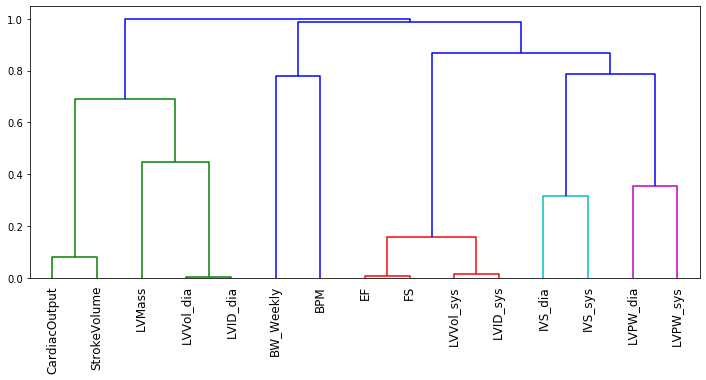

[ 0  1  2  3  5 11 14  4  6 12 13  7  8  9 10]
22 months (685, 18)
22 months (685, 15)
[ 0  1  2  3  5 11 14  4  6 12 13  7  8  9 10]
34 months (236, 18)
34 months (236, 15)
[ 0  1  2  3  5 11 14  4  6 12 13  7  8  9 10]


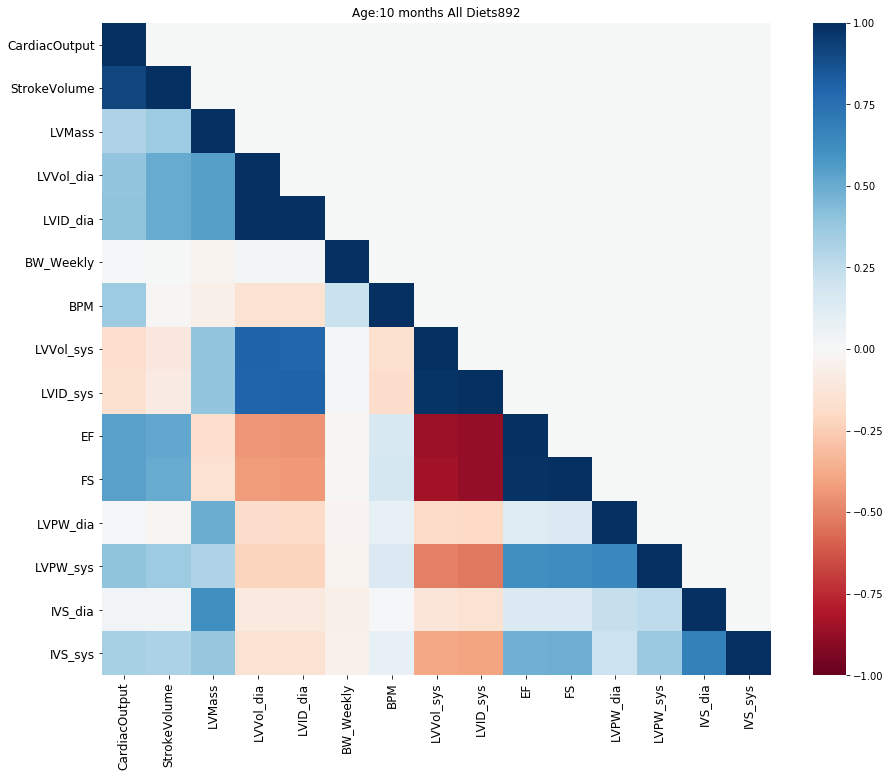

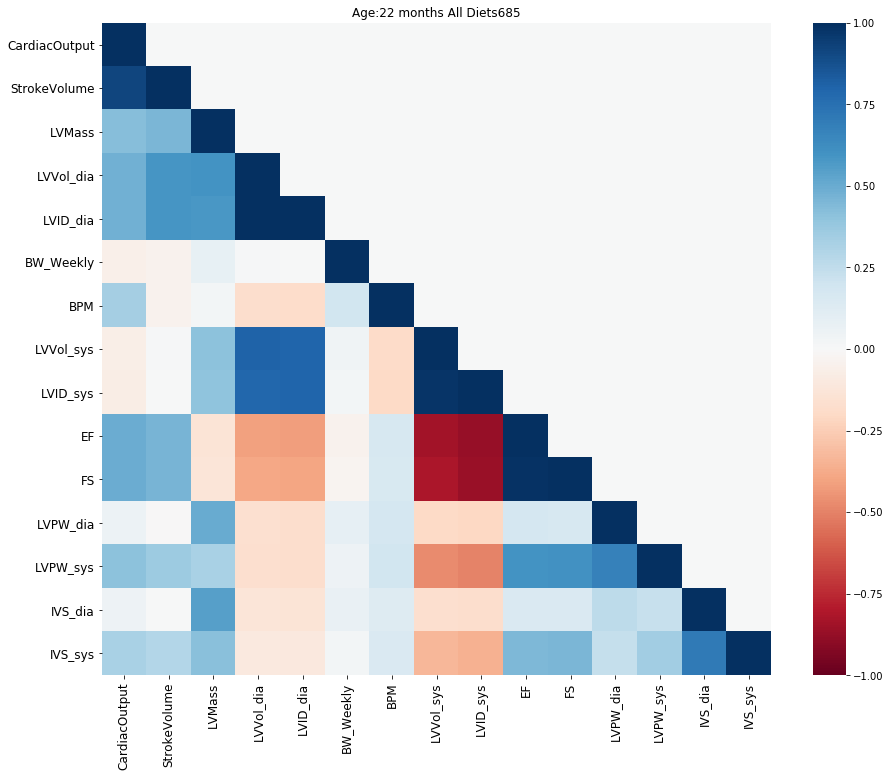

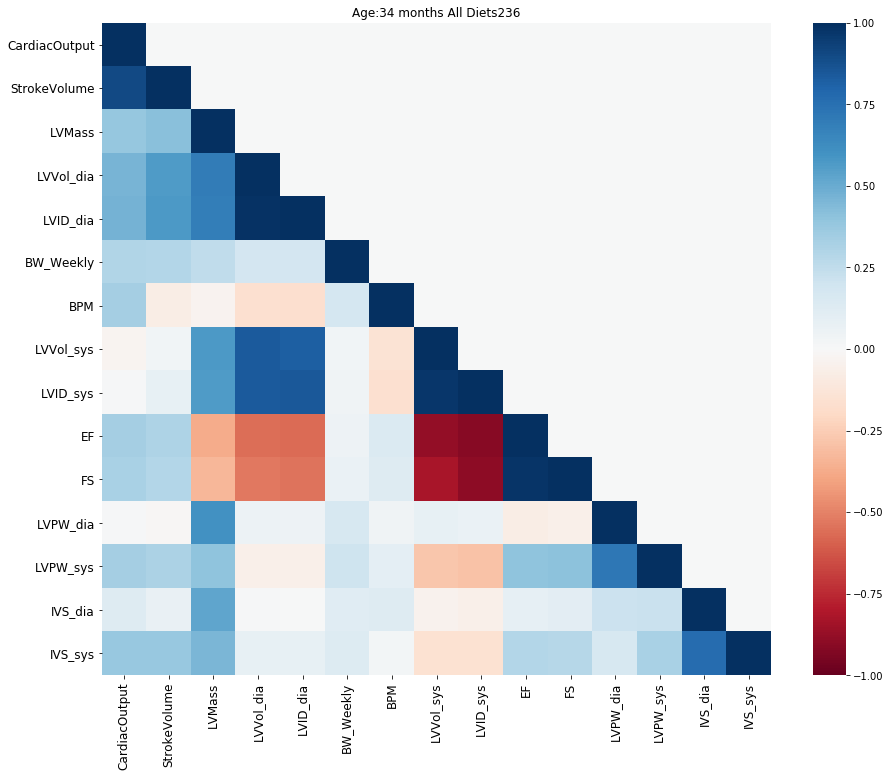

In [5]:
##from -- https://www.kaggle.com/sgalella/correlation-heatmaps-with-hierarchical-clustering

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
output_yr123_file = working_dir+"echo_yr123_20210920.csv"
df = pd.read_csv(output_yr123_file)

grp_age = df.groupby('Timepoint'); i = 0
labels_order = ''
labels = ''
for name0, group0 in grp_age:

    print (name0, group0.shape)
    tmp = group0.drop(['MouseID','Timepoint','AgeInDays'],axis=1)
    print (name0, tmp.shape)
    
    ##conduct all pairwise correlations
    corr = tmp.corr(method='pearson').values
    dissim = 1 - abs(corr)
    
    Z = linkage(squareform(dissim), 'complete')  ##what is squareform(dissim) - convert vector to matrix.
    
    if name0 == '10 months':
        plt.figure(figsize=(12,5))
        dendrogram(Z, labels=tmp.columns, orientation='top', leaf_rotation=90)
        plt.show()

    # sort data at 3mon values, keep for all others
    if name0 == '10 months':
        # Clusterize the data
        threshold = 0.8
        labels = fcluster(Z, threshold, criterion='distance')
        labels_order = np.argsort(labels)  ##keep order the same for all five ages
    print(labels_order)
    
    # Build a new dataframe with the sorted columns
    for idx, i in enumerate(tmp.columns[labels_order]):
        if idx == 0:
            clustered = pd.DataFrame(tmp[i])
        else:
            df_to_append = pd.DataFrame(tmp[i])
            clustered = pd.concat([clustered, df_to_append], axis=1)
    ##plot cluster
    fig, axs = plt.subplots(figsize=(15,12), 
                nrows=1, ncols=1,     
                gridspec_kw=dict(hspace=0.2, wspace=0.2) )
    correlations = clustered.corr()
    correlations = np.tril(correlations)
    #sns.heatmap(correlations, cmap='RdBu',  vmin=-1.0, vmax=1.0) #annot=True, annot_kws={"size": 7},
    plt.title('Age:'+str(name0)+' All Diets'+str(len(group0['Timepoint'])))
    #p = sns.clustermap(correlations, method="complete", cmap='RdBu', annot=True,  ##use this to recluster each iteration. 
    #           annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12))
    sns.heatmap(correlations, cmap='RdBu', annot=False, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, ax=axs)

    yy=list(clustered.columns)
    #yy.reverse()
    time_months = re.sub(' ', '',name0)
    axs.set_xticklabels(yy, rotation = 90, size=12)
    axs.set_yticklabels(yy, rotation = 0, size=12)
    fig.savefig(working_dir+'clustermap_'+time_months+'_alldiets.png', dpi=400)  



      MouseID  Timepoint  AgeInDays  CardiacOutput  StrokeVolume      LVMass  \
0  DO-AL-0001  10 months        314   14630.110396     24.913846   91.682280   
1  DO-AL-0001  22 months        688   18348.573022     36.288008  105.029587   

   LVVol_dia  LVVol_sys  LVID_dia  LVID_sys  LVPW_dia  LVPW_sys   IVS_dia  \
0  55.922639  34.464691  3.652038  2.922979  0.660918  0.898593  0.774830   
1  55.379120  21.854992  3.627296  2.431906  0.867990  1.095320  0.678331   

    IVS_sys  BW_Weekly         EF         FS         BPM diet  
0  0.995789   33.66609  42.266473  20.882916  572.788533   AL  
1  1.113835   28.05214  63.845552  33.725502  482.650281   AL  
1D (339, 19)
1D (339, 15)


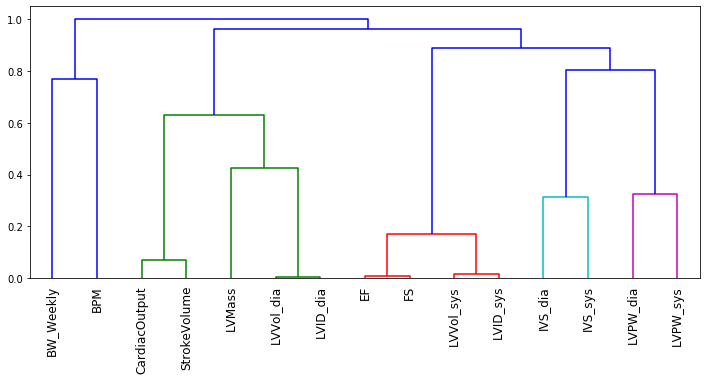

[11 14  0  1  2  3  5  4  6 12 13  9 10  7  8]
20 (374, 19)
20 (374, 15)
[11 14  0  1  2  3  5  4  6 12 13  9 10  7  8]
2D (357, 19)
2D (357, 15)
[11 14  0  1  2  3  5  4  6 12 13  9 10  7  8]
40 (422, 19)
40 (422, 15)
[11 14  0  1  2  3  5  4  6 12 13  9 10  7  8]
AL (321, 19)
AL (321, 15)
[11 14  0  1  2  3  5  4  6 12 13  9 10  7  8]


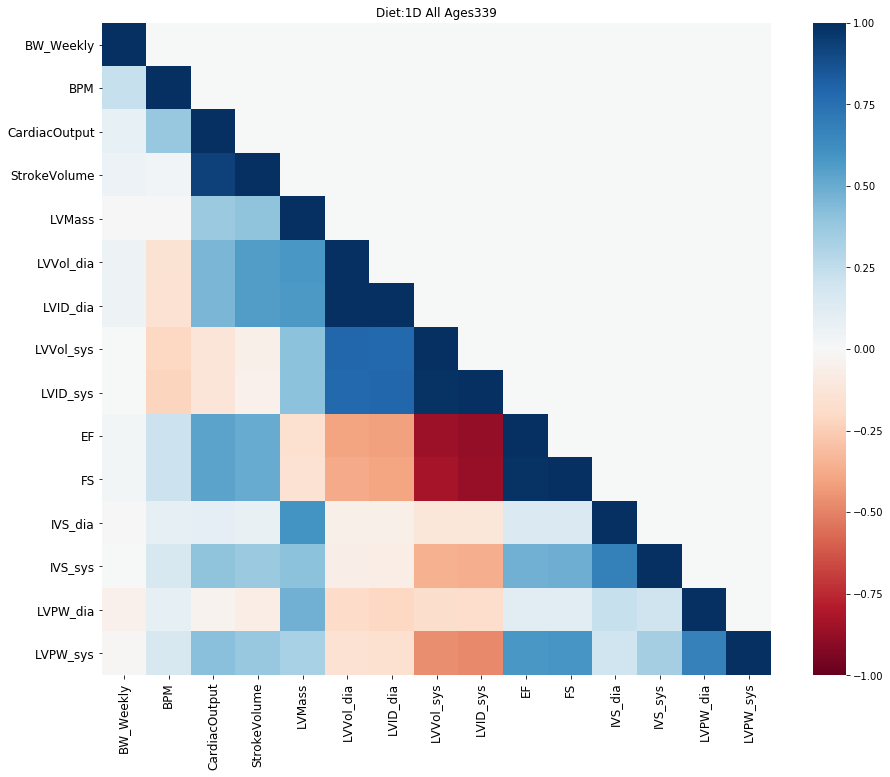

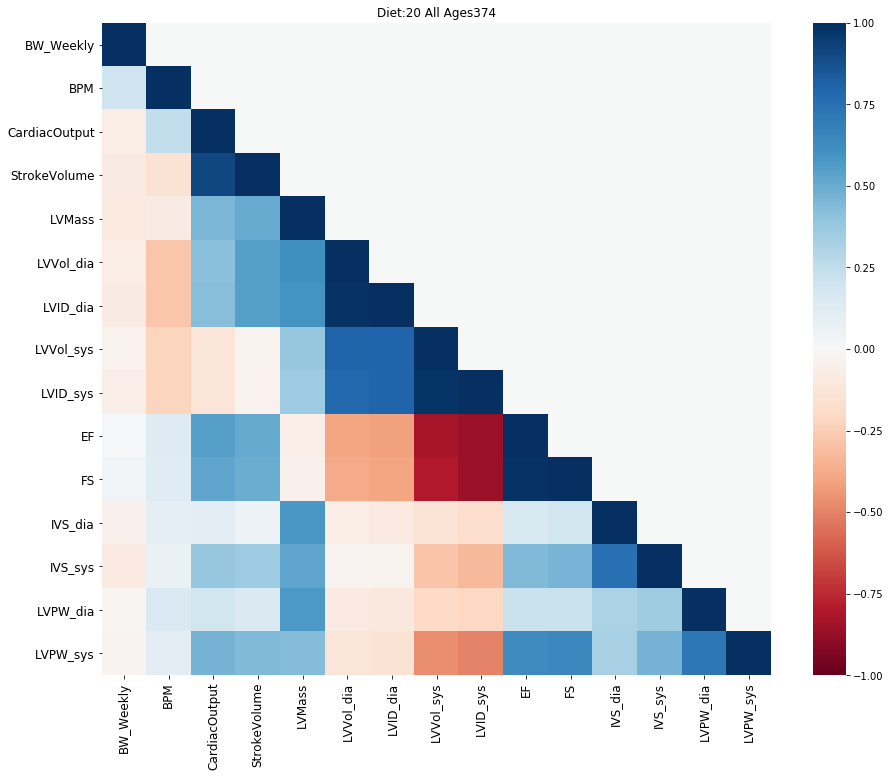

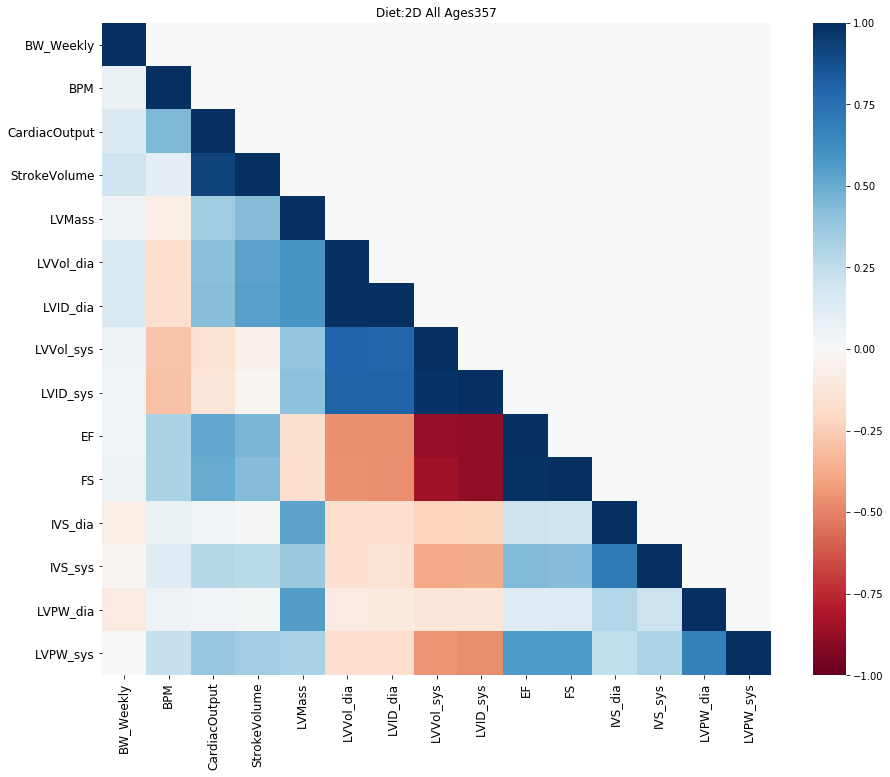

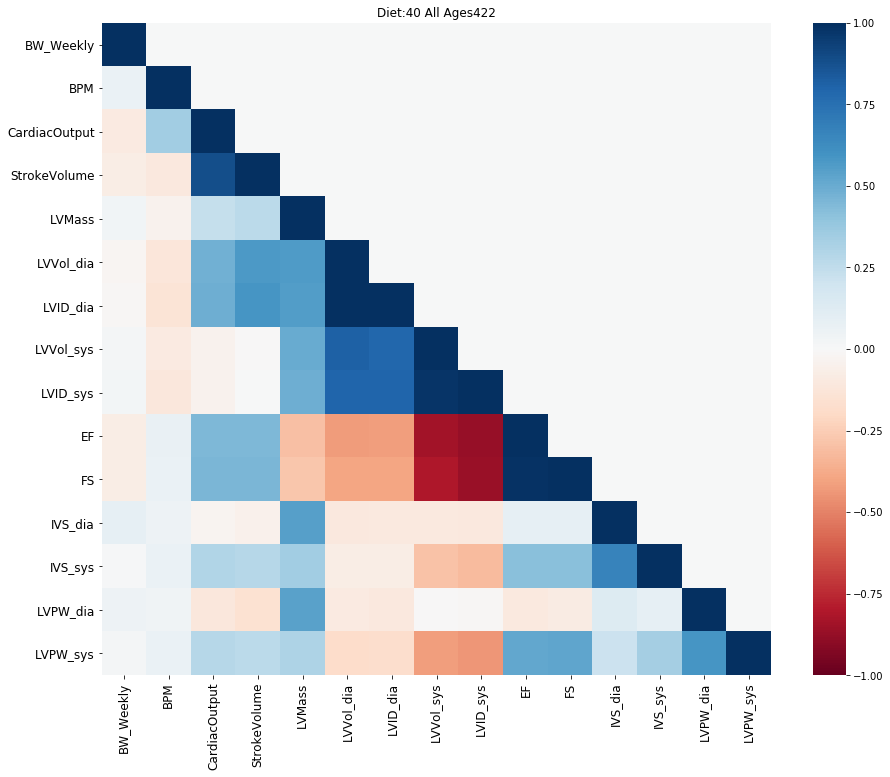

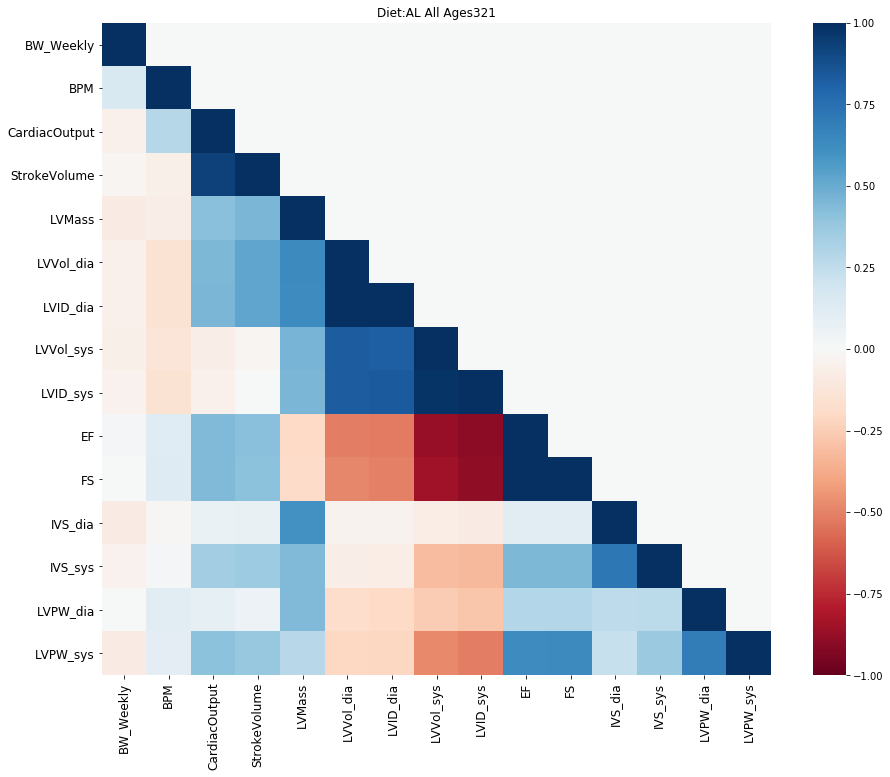

In [48]:
##from -- https://www.kaggle.com/sgalella/correlation-heatmaps-with-hierarchical-clustering

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
output_yr123_file = working_dir+"echo_yr123_20210920.csv"
df = pd.read_csv(output_yr123_file)
df['diet'] = df['MouseID'].str.replace('^DO-','')
df['diet'] = df['diet'].str.replace('-\d\d\d\d$','')
print(df.head(n=2))

grp_diet = df.groupby('diet'); i = 0
labels_order = ''
labels = ''
for name0, group0 in grp_diet:

    print (name0, group0.shape)
    tmp = group0.drop(['MouseID','Timepoint','AgeInDays', 'diet'],axis=1)
    print (name0, tmp.shape)

    ##conduct all pairwise correlations
    corr = tmp.corr(method='pearson').values
    dissim = 1 - abs(corr)
    
    Z = linkage(squareform(dissim), 'complete')  ##what is squareform(dissim) - convert vector to matrix.
    
    if name0 == '1D':
        plt.figure(figsize=(12,5))
        dendrogram(Z, labels=tmp.columns, orientation='top', leaf_rotation=90)
        plt.show()

    # sort data at 3mon values, keep for all others
    if name0 == '1D':
        # Clusterize the data
        threshold = 0.8
        labels = fcluster(Z, threshold, criterion='distance')
        labels_order = np.argsort(labels)  ##keep order the same for all five ages
    print(labels_order)
    
    # Build a new dataframe with the sorted columns
    for idx, i in enumerate(tmp.columns[labels_order]):
        if idx == 0:
            clustered = pd.DataFrame(tmp[i])
        else:
            df_to_append = pd.DataFrame(tmp[i])
            clustered = pd.concat([clustered, df_to_append], axis=1)
    ##plot cluster
    fig, axs = plt.subplots(figsize=(15,12), 
                nrows=1, ncols=1,     
                gridspec_kw=dict(hspace=0.2, wspace=0.2) )
    correlations = clustered.corr()
    correlations = np.tril(correlations)
    #sns.heatmap(correlations, cmap='RdBu',  vmin=-1.0, vmax=1.0) #annot=True, annot_kws={"size": 7},
    plt.title('Diet:'+str(name0)+' All Ages'+str(len(group0['BPM'])))
    #p = sns.clustermap(correlations, method="complete", cmap='RdBu', annot=True,  ##use this to recluster each iteration. 
    #           annot_kws={"size": 7}, vmin=-1, vmax=1, figsize=(15,12))
    sns.heatmap(correlations, cmap='RdBu', annot=False, 
               annot_kws={"size": 7}, vmin=-1, vmax=1, ax=axs)

    yy=list(clustered.columns)
    #yy.reverse()
    axs.set_xticklabels(yy, rotation = 90, size=12)
    axs.set_yticklabels(yy, rotation = 0, size=12)
    fig.savefig(working_dir+'clustermap_diet'+name0+'_allages.png', dpi=400)  



### clustering conclusions
    age and diet have little effect on phenotypic correlations between traits.
    this is partly because multiple echo traits are derived from each other. 
    
    focal traits for qtl mapping:
    LVPW_dia, LVMass - cardiac hypertropy
    CardiacOutput, EF(ejection fraction) - cardiac efficency, heart systolic function - eg heart's ability to contract
    

## 2. Run Analysis - calc PVE

In [51]:
output_yr1_file = working_dir+"echo_yr1_20210920.csv"
output_yr2_file = working_dir+"echo_yr2_20210920.csv"
output_yr3_file = working_dir+"echo_yr3_20210920.csv"
phenotype_files = [output_yr1_file, output_yr2_file, output_yr3_file] 

df = pd.read_csv(output_yr1_file)
phenotype_list = df.columns[3:]
phenotype_focal = ['CardiacOutput', 'EF', 'LVMass', 'LVPW_dia']

In [13]:
###### directories
genetics_dir = "/group/diversity_outcross/genetics/jax/geno_data_proc/"
working_dir = "/home/wright/do_qtl/echo/"
script_dir = "/home/wright/do_qtl/analysis/"
log_dir = working_dir+"logs/"
###### files
#phenotype_file = pheno_yr1_file
#phenotype_list = ["CardiacOutput"]
covar_dir = "/group/diversity_outcross/nonmetabolic_cage/jax/"
covar_diet = covar_dir+"diet_covariates.csv"
covar_gen = covar_dir+"generation_covariates.csv"
kinship_file = genetics_dir+"kinship_matrix.genoprob.csv" ##double check with Anil - from genotypes or genoprobs?

for phenotype_file in phenotype_files:
    for phenotype in phenotype_focal:
        output_pve_file = phenotype_file
        output_pve_file = re.sub('.csv$','_'+phenotype+'.pve.csv',output_pve_file)

        if os.path.exists(output_pve_file) is False:
            log_file = output_pve_file+".log"
            log_file = re.sub(working_dir, log_dir, log_file)
            
            script_gwas = script_dir+"run_pve_analysis.py"
            sbatch_script = script_gwas+"_"+phenotype+".sh"
            fOUT = open(sbatch_script, 'w')
            print ("#!/bin/bash", file=fOUT)
            print ("#SBATCH --cpus-per-task=1", file=fOUT)
            print ("#SBATCH --ntasks-per-node=1", file=fOUT) 
            print ("#SBATCH --mem-per-cpu=5400", file=fOUT)
            print ( "#SBATCH --job-name=pve", file=fOUT)
            print ( "#SBATCH --partition=standard", file=fOUT)
            print ( "#SBATCH --output="+log_file, file=fOUT)
            print ( "#SBATCH --error="+log_file+".err", file=fOUT)

            print ( "source activate mypython3", file=fOUT)
            print ( "python "+script_gwas+" --phenotype_file "+phenotype_file+ " --phenotype "+phenotype + \
                   " --covar_diet_file "+covar_diet + " --covar_gen_file "+covar_gen+" --kinship_file "+kinship_file, file=fOUT)
            fOUT.close()

            !ssh wright@cb "cd {working_dir}; sbatch {sbatch_script} "
            print (log_file)


Submitted batch job 22463783
/home/wright/do_qtl/echo/logs/echo_yr2_20210920_EF.pve.csv.log


In [7]:
#print (log_file)
log_file = "/home/wright/do_qtl/echo/logs/echo_yr3_20210920_LVPW_dia.pve.csv.log"
!ssh cb "squeue -u wright"
!ssh cb "head -n 4000 {log_file}"
!ssh cb "head -n 400 {log_file}.err"

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          22432873  standard      pve   wright  R   14:48:20      1 n0045
/home/wright/do_qtl/echo/echo_yr3_20210920.csv LVPW_dia /group/diversity_outcross/nonmetabolic_cage/jax/diet_covariates.csv /group/diversity_outcross/nonmetabolic_cage/jax/generation_covariates.csv /group/diversity_outcross/genetics/jax/geno_data_proc/kinship_matrix.genoprob.csv
['AL', '20', '40', '1D', '2D']
['G22W1', 'G22W2', 'G23W1', 'G23W2', 'G24W1', 'G24W2', 'G26W1', 'G26W2', 'G27W1', 'G27W2', 'G28W1', 'G28W2']
n samples 235
estimating PVE with 10 random runs ...
completed run 1; log likelihood = 109.9003
completed run 2; log likelihood = 109.4303
completed run 3; log likelihood = 109.9003
completed run 4; log likelihood = 109.9003
completed run 5; log likelihood = 109.9003
completed run 6; log likelihood = 109.4303
completed run 7; log likelihood = 109.9003
completed run 8; log likelihood = 109.9003
completed run 9; log lik

### 2B plot PVE

In [8]:
output_yr1_file = working_dir+"echo_yr1_20210920.csv"
output_yr2_file = working_dir+"echo_yr2_20210920.csv"
output_yr3_file = working_dir+"echo_yr3_20210920.csv"
phenotype_files = [output_yr1_file, output_yr2_file, output_yr3_file] 

df = pd.read_csv(output_yr1_file)
phenotype_list = df.columns[3:]
phenotype_focal = ['CardiacOutput', 'EF', 'LVMass', 'LVPW_dia']

In [11]:
lsp = []
for phenotype_file in phenotype_files:
    for phenotype in phenotype_focal:
        output_pve_file = phenotype_file
        output_pve_file = re.sub('.csv$','_'+phenotype+'.pve.csv',output_pve_file)
        yr = re.sub(working_dir+"echo_","",phenotype_file)
        yr = re.sub('_20210920.csv$',"",yr)
        #print(adj,yr, output_pve_file)
        
        if os.path.exists(output_pve_file) is True:
            df = pd.read_csv(output_pve_file, index_col=False, usecols=range(12))
            df['yr'] = yr
            df['phenotype'] = phenotype
            lsp.append(df) 

dfp = pd.concat(lsp)
dfp.head(n=18)

,total_pve,total_pve_se,AL_pve,AL_pve_se,20_pve,20_pve_se,40_pve,40_pve_se,1D_pve,1D_pve_se,2D_pve,2D_pve_se,yr,phenotype
0,0.2362,0.0032,0.2768,0.0054,0.2569,0.0070,0.2490,0.0059,0.2224,0.0059,0.2116,0.0097,yr1,CardiacOutput
0,0.1077,0.0175,0.1060,0.0243,0.0949,0.0153,0.1351,0.0146,0.1144,0.0254,0.1152,0.0192,yr1,EF
0,0.0984,0.0214,0.0844,0.0185,0.1101,0.0230,0.1010,0.0249,0.1063,0.0239,0.0972,0.0220,yr1,LVMass
0,0.0361,0.0118,0.0381,0.0133,0.0323,0.0105,0.0386,0.0152,0.0308,0.0098,0.0429,0.0142,yr1,LVPW_dia
0,0.1614,0.0006,0.1427,0.0009,0.1580,0.0009,0.2346,0.0014,0.1381,0.0009,0.1595,0.0008,yr2,CardiacOutput
0,0.0901,0.0412,0.0654,0.0298,0.1023,0.0488,0.1390,0.0647,0.0938,0.0446,0.0871,0.0394,yr2,LVMass
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,yr2,LVPW_dia
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,yr3,CardiacOutput
0,0.2857,0.1557,0.1461,0.0800,0.5690,0.2780,0.3326,0.1992,0.2374,0.1268,0.2570,0.1386,yr3,EF
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,yr3,LVMass


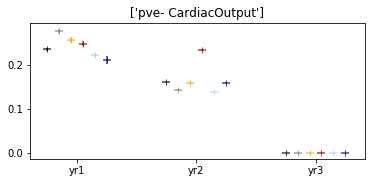

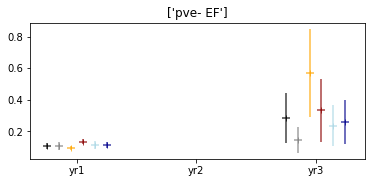

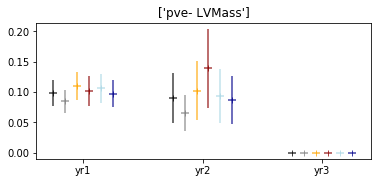

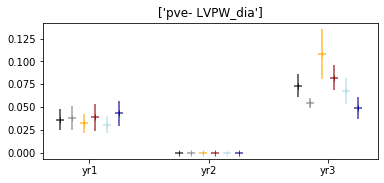

In [56]:

df1 = dfp.groupby(['phenotype'])
#random.seed(9001)
##set jitter for each diet
random.seed(8001)
jitter_T = -0.25
jitter_AL = -0.15
jitter_20 = -0.05
jitter_40 = 0.05
jitter_1D = 0.15
jitter_2D = 0.25

for idx1, grp1 in df1:

    fig, axs = plt.subplots(figsize=(6,2.5), 
                    nrows=1, ncols=1,     # fix as above
                    gridspec_kw=dict(hspace=0.4),
                    sharey=True)

    titles = ['pve- '+idx1]
    plt.title(titles)
    
    yr_ids = {'yr1': 1, 'yr2': 2, 'yr3': 3}

    grp1['yr_id'] = grp1['yr'].apply(lambda x: yr_ids[x])
    
    axs.scatter(grp1['yr_id']+jitter_T, grp1['total_pve'],s=80, marker="_", color='black', alpha=0.75)
    axs.errorbar(grp1['yr_id']+jitter_T, grp1['total_pve'], yerr=grp1['total_pve_se'], fmt='|', color='black', alpha=0.75)
    axs.scatter(grp1['yr_id']+jitter_AL, grp1['AL_pve'],s=80, marker="_", color='grey', alpha=0.75)
    axs.errorbar(grp1['yr_id']+jitter_AL, grp1['AL_pve'], yerr=grp1['AL_pve_se'], fmt='|', color='grey', alpha=0.75)
    axs.scatter(grp1['yr_id']+jitter_20, grp1['20_pve'],s=80, marker="_", color='orange', alpha=0.75)
    axs.errorbar(grp1['yr_id']+jitter_20, grp1['20_pve'], yerr=grp1['20_pve_se'], fmt='|', color='orange', alpha=0.75)
    
    axs.scatter(grp1['yr_id']+jitter_40, grp1['40_pve'],s=80, marker="_", color='darkred', alpha=0.75)
    axs.errorbar(grp1['yr_id']+jitter_40, grp1['40_pve'], yerr=grp1['40_pve_se'], fmt='|', color='darkred', alpha=0.75)
    axs.scatter(grp1['yr_id']+jitter_1D, grp1['1D_pve'],s=80, marker="_", color='lightblue', alpha=0.75)
    axs.errorbar(grp1['yr_id']+jitter_1D, grp1['1D_pve'], yerr=grp1['1D_pve_se'], fmt='|', color='lightblue', alpha=0.75)
    axs.scatter(grp1['yr_id']+jitter_2D, grp1['2D_pve'],s=80, marker="_", color='darkblue', alpha=0.75)
    axs.errorbar(grp1['yr_id']+jitter_2D, grp1['2D_pve'], yerr=grp1['2D_pve_se'], fmt='|', color='darkblue', alpha=0.75)
    axs.set_xticks([1, 2, 3])
    axs.set_xticklabels(['yr1','yr2','yr3'])
    fig.savefig(working_dir+'pve_x_age_'+idx1+'.png', dpi=400)

    #figure.text(0.5, -0.1, 'true h2_env1. res_var2'+str(res_var2_tmp), fontsize=10, horizontalalignment='center', verticalalignment='bottom')
    #_ = figure.text(0., 0.5, 'estimated h2_env1', fontsize=10, horizontalalignment='left', verticalalignment='center', rotation=90)
    plt.show()


## 3. Run GWAS + Estimate Effects

In [4]:
phenotype_files = [pheno_bwadj_yr1_file, pheno_bwadj_yr2_file, pheno_bwadj_yr21_file, pheno_bwadj_yr3_file]
df = pd.read_csv(pheno_bwadj_yr1_file)
phenotype_list = df.columns[3:19]
print(phenotype_list)
print(phenotype_files)

Index(['BPM', 'CardiacOutput', 'StrokeVolume', 'EF', 'FS', 'LVMass',
       'LVMassCorrected', 'LVVol_dia', 'LVVol_sys', 'LVID_dia', 'LVID_sys',
       'LVPW_dia', 'LVPW_sys', 'IVS_dia', 'IVS_sys', 'BW_Test'],
      dtype='object')
['/home/wright/do_qtl/echo/echo_batch.bw.adj.yr1.csv', '/home/wright/do_qtl/echo/echo_batch.bw.adj.yr2.csv', '/home/wright/do_qtl/echo/echo_batch.bw.adj.yr21.csv', '/home/wright/do_qtl/echo/echo_batch.bw.adj.yr3.csv']


In [5]:
genetics_dir = "/group/diversity_outcross/genetics/jax/geno_data_proc/"

working_dir = "/home/wright/do_qtl/echo/"
script_dir = "/home/wright/do_qtl/analysis/"
log_dir = working_dir+"logs/"

chrm_list = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 'X']
#chrm_list = ['16']
phenotype_list = ['StrokeVolume']
covar_dir = "/group/diversity_outcross/nonmetabolic_cage/jax/"
covar_diet = covar_dir+"diet_covariates.csv"
covar_gen = covar_dir+"generation_covariates.csv"
kinship_file = genetics_dir+"kinship_matrix.genoprob.csv" ##double check with Anil - from genotypes or genoprobs?
for phenotype_file in phenotype_files:
    for phenotype in phenotype_list:
        for chrm in chrm_list:
            output_qtl_file = phenotype_file
            output_qtl_file = re.sub('.csv$','_'+phenotype+'_'+chrm+'.qtl.csv',output_qtl_file)

            if os.path.exists(output_qtl_file) is False:
                log_file = output_qtl_file+".log"
                log_file = re.sub(working_dir, log_dir, log_file)
                genotype_file = genetics_dir+"prob.8state.allele.qtl2_200131.Rdata."+chrm+".csv"

                script_gwas = script_dir+"run_gwa_analysis.py"
                sbatch_script = script_gwas+"_"+chrm+".sh"
                fOUT = open(sbatch_script, 'w')
                print ("#!/bin/bash", file=fOUT)
                print ("#SBATCH --cpus-per-task=1", file=fOUT)
                print ("#SBATCH --ntasks-per-node=1", file=fOUT) 
                print ("#SBATCH --mem-per-cpu=5400", file=fOUT)
                print ( "#SBATCH --job-name=qtl_gxemm", file=fOUT)
                print ( "#SBATCH --partition=standard", file=fOUT)
                print ( "#SBATCH --output="+log_file, file=fOUT)
                print ( "#SBATCH --error="+log_file+".err", file=fOUT)

                print ( "source activate mypython3", file=fOUT)
                print ( "python "+script_gwas+" --chromosome "+chrm+" --genotype_file "+genotype_file + \
                       " --phenotype_file "+phenotype_file+ " --phenotype "+phenotype + \
                       " --covar_diet_file "+covar_diet + " --covar_gen_file "+covar_gen + \
                       " --kinship_file "+kinship_file, file=fOUT)
                fOUT.close()
                !ssh wright@cb "cd {working_dir}; sbatch {sbatch_script} "
                print (log_file)
                
            ####################################################################
            #### gwas effects
            output_effect_file = phenotype_file
            output_effect_file = re.sub('.csv$','_'+phenotype+'_'+chrm+'.eff.csv',output_effect_file)
            
            if os.path.exists(output_qtl_file) is False:
                log_file = output_effect_file+".log"
                log_file = re.sub(working_dir, log_dir, log_file)

                script_effects = script_dir+"run_gxemm_effects.py"
                sbatch_script = script_gwas+"_"+chrm+".sh"
                fOUT = open(sbatch_script, 'w')
                print ("#!/bin/bash", file=fOUT)
                print ("#SBATCH --cpus-per-task=1", file=fOUT)
                print ("#SBATCH --ntasks-per-node=1", file=fOUT) 
                print ("#SBATCH --mem-per-cpu=5400", file=fOUT)
                print ( "#SBATCH --job-name=effect_gxemm", file=fOUT)
                print ( "#SBATCH --partition=standard", file=fOUT)
                print ( "#SBATCH --output="+log_file, file=fOUT)
                print ( "#SBATCH --error="+log_file+".err", file=fOUT)

                print ( "source activate mypython3", file=fOUT)
                print ( "python "+script_effects+" --chromosome "+chrm+" --genotype_file "+genotype_file + \
                       " --phenotype_file "+phenotype_file+ " --phenotype "+phenotype + \
                       " --covar_diet_file "+covar_diet + " --covar_gen_file "+covar_gen + \
                       " --kinship_file "+kinship_file, file=fOUT)

                fOUT.close()
                !ssh wright@cb "cd {working_dir}; sbatch {sbatch_script} "
                print (log_file)


Submitted batch job 22390082
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr1_StrokeVolume_1.qtl.csv.log
Submitted batch job 22390083
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr1_StrokeVolume_1.eff.csv.log
Submitted batch job 22390084
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr1_StrokeVolume_2.qtl.csv.log
Submitted batch job 22390085
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr1_StrokeVolume_2.eff.csv.log
Submitted batch job 22390086
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr1_StrokeVolume_3.qtl.csv.log
Submitted batch job 22390087
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr1_StrokeVolume_3.eff.csv.log
Submitted batch job 22390088
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr1_StrokeVolume_4.qtl.csv.log
Submitted batch job 22390089
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr1_StrokeVolume_4.eff.csv.log
Submitted batch job 22390090
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr1_StrokeVolume_5.qtl.csv.log
Submitted batch job 22390091

Submitted batch job 22390158
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr2_StrokeVolume_19.qtl.csv.log
Submitted batch job 22390159
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr2_StrokeVolume_19.eff.csv.log
Submitted batch job 22390160
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr2_StrokeVolume_X.qtl.csv.log
Submitted batch job 22390161
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr2_StrokeVolume_X.eff.csv.log
Submitted batch job 22390162
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr21_StrokeVolume_1.qtl.csv.log
Submitted batch job 22390163
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr21_StrokeVolume_1.eff.csv.log
Submitted batch job 22390164
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr21_StrokeVolume_2.qtl.csv.log
Submitted batch job 22390165
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr21_StrokeVolume_2.eff.csv.log
Submitted batch job 22390166
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr21_StrokeVolume_3.qtl.csv.log
Submitted batch job 2

/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr3_StrokeVolume_16.eff.csv.log
Submitted batch job 22390235
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr3_StrokeVolume_17.qtl.csv.log
Submitted batch job 22390236
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr3_StrokeVolume_17.eff.csv.log
Submitted batch job 22390237
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr3_StrokeVolume_18.qtl.csv.log
Submitted batch job 22390238
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr3_StrokeVolume_18.eff.csv.log
Submitted batch job 22390239
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr3_StrokeVolume_19.qtl.csv.log
Submitted batch job 22390240
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr3_StrokeVolume_19.eff.csv.log
Submitted batch job 22390241
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr3_StrokeVolume_X.qtl.csv.log
Submitted batch job 22390242
/home/wright/do_qtl/echo/logs/echo_batch.bw.adj.yr3_StrokeVolume_X.eff.csv.log


In [62]:
print (log_file)
#log_file = "/home/wright/do_mice/qtl_lifespan_gxemm/logs/gxemm_chrm18.qtl.log"
!ssh cb "squeue -u wright"
!ssh cb "head -n 4000 {log_file}"
!ssh cb "head -n 400 {log_file}.err"

/home/wright/do_qtl/echo/logs/effects_chrm18_CardiacOutput.log
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          22352760  standard subset_v   wright  R   21:07:46      1 n0044
          22352762  standard subset_v   wright  R   21:07:46      1 n0045
          22352759  standard subset_v   wright  R   21:07:49      1 n0012
          22386161  standard      pve   wright  R       5:33      1 n0003
          22386162  standard      pve   wright  R       5:33      1 n0003
          22386163  standard      pve   wright  R       5:33      1 n0003
          22386160  standard      pve   wright  R       5:36      1 n0003
          22386168  standard effect_g   wright  R       0:03      1 n0003
          22386167  standard qtl_gxem   wright  R       0:06      1 n0003


## 4. Find Candidate Loci

## 5. Run Fine Mapping Analysis

In [23]:
working_dir = "/home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/"
output_dir = "/home/wright/do_mice/qtl_lifespan_gxemm/"
script_dir = "/home/wright/diversity_outcross/analysis/qtl/"
log_dir = output_dir+"logs/"

script_file = script_dir+"run_finemap_genoprob_analysis_ls.py" 
sbatch_script = script_file+".sh"

sigloci_dict = {
            '16':['4000000','13500000'],
            '1':['2000000','4000000'],    ##st & end in bp, not Mb
            '6':['98000000','108000000'], 
            '9':['11000000','18000000'], 
            '14':['107000000','121000000'], 
            '18':['15000000','25000000']
            }
model = 'gxe' #'emma'
phenotype = 'Lifespan.Zsc'
#focal_pop = 'jac'
focal_pop = 'all'

#input files
if focal_pop == 'all':
    phenotype_file = working_dir+"source_data_dir/lifespan_pheno_200326.csv"
    #covar_add_file = "/home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/source_data_dir/covar_gen_200326.csv"
    covar_inter_file = "/home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/source_data_dir/covar_diet_200326.csv"
    covar_add_file = "/home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/source_data_dir/covar_gen.sty.sex_200326.csv"
    #covar_add_file = 'NA'
    covar_add = 'gen.sty.sex'
    covar_inter = 'diet'

if focal_pop == 'jac':
    phenotype_file = working_dir+"source_data_dir/lifespan_jac.csv"
    covar_add_file = working_dir+"source_data_dir/covar_gen_study_jac.csv"
    #covar_add_file = 'NA'
    covar_inter_file = working_dir+"source_data_dir/covar_sex_study_jac.csv"
    covar_add = 'gen'
    covar_inter = 'sex'
    
for chrm in sigloci_dict:
    locus_st = sigloci_dict[chrm][0]
    locus_end = sigloci_dict[chrm][1]
        
    output_file = output_dir+"fine_"+focal_pop+"_add.cov"+covar_add+"_int.cov"+covar_inter+"_chrm"+chrm+"."+locus_st+".csv"
    log_file = log_dir+"fine_"+focal_pop+"_add.cov"+covar_add+"_int.cov"+covar_inter+"_chrm"+chrm+"."+locus_st+".log"
    
    fOUT = open(sbatch_script, 'w')
    print ("#!/bin/bash", file=fOUT)
    print ("#SBATCH --cpus-per-task=1", file=fOUT)
    print ("#SBATCH --ntasks-per-node=1", file=fOUT) 
    print ("#SBATCH --mem-per-cpu=8400", file=fOUT)
    print ( "#SBATCH --job-name=fine_ls", file=fOUT)
    print ( "#SBATCH --partition=standard", file=fOUT)
    print ( "#SBATCH --output="+log_file, file=fOUT)
    print ( "#SBATCH --error="+log_file+".err", file=fOUT)

    print ( "source activate mypython3", file=fOUT)
    print ( "python "+script_file+" "+chrm+" "+locus_st+" "+locus_end+" "+phenotype_file+" "+phenotype+" "+covar_add_file+" "+covar_inter_file+" "+model+" "+output_file, file=fOUT)
    fOUT.close()

    !ssh wright@cb "cd {working_dir}; sbatch {sbatch_script} "
    print (log_file)

    

Submitted batch job 13907200
/home/wright/do_mice/qtl_lifespan_gxemm/logs/fine_all_add.covgen.sty.sex_int.covdiet_chrm16.4000000.log
Submitted batch job 13907201
/home/wright/do_mice/qtl_lifespan_gxemm/logs/fine_all_add.covgen.sty.sex_int.covdiet_chrm1.2000000.log
Submitted batch job 13907202
/home/wright/do_mice/qtl_lifespan_gxemm/logs/fine_all_add.covgen.sty.sex_int.covdiet_chrm6.98000000.log
Submitted batch job 13907203
/home/wright/do_mice/qtl_lifespan_gxemm/logs/fine_all_add.covgen.sty.sex_int.covdiet_chrm9.11000000.log
Submitted batch job 13907204
/home/wright/do_mice/qtl_lifespan_gxemm/logs/fine_all_add.covgen.sty.sex_int.covdiet_chrm14.107000000.log
Submitted batch job 13907205
/home/wright/do_mice/qtl_lifespan_gxemm/logs/fine_all_add.covgen.sty.sex_int.covdiet_chrm18.15000000.log


In [28]:
print (log_file)
#log_file = '/home/wright/do_mice/qtl_lifespan_gxemm/logs/lifespan_jac_chrm18.log'
!ssh cb "squeue -u wright -n fine_ls"
!ssh cb "head -n 4000 {log_file}"
!ssh cb "head -n 400 {log_file}.err"

/home/wright/do_mice/qtl_lifespan_gxemm/logs/fine_all_add.covgen.sty.sex_int.covdiet_chrm18.15000000.log
             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
          13907203  standard  fine_ls   wright  R       2:15      1 d03
          13907204  standard  fine_ls   wright  R       2:15      1 n0003
          13907205  standard  fine_ls   wright  R       2:15      1 n0004
          13907200  standard  fine_ls   wright  R       2:17      1 d03
          13907201  standard  fine_ls   wright  R       2:17      1 n0045
          13907202  standard  fine_ls   wright  R       2:17      1 n0002
          13907162  standard  fine_ls   wright  R       4:18      1 d02
          13907163  standard  fine_ls   wright  R       4:18      1 n0045
          13907156  standard  fine_ls   wright  R       4:20      1 d01
          13907157  standard  fine_ls   wright  R       4:20      1 d01
          13907159  standard  fine_ls   wright  R       4:20      1 d01
        

## Appendix 1- testing pve code

In [ ]:
# Testing PVE model fit 
model = gxemm.Gxemm(genotype.kinship,
                    phenotype.data,
                    covariates)

model.fit_pve(get_serr=True)

##print
print(model.sigma)  # noise terms, first is shared noise. gene x diet -- whatever gxe_test=True. often sigma can be zero
print(model.omega)  # diet + gen specific noise, Var_Err . this can often be high, and diet specific. leading to large deviations from gxemm and emma.
print(model.rho)    # additive variance --- emma total variance result

print("Total PVE = %.4f; Std. err = %.4f"%(model.total_pve, model.total_pve_serr))

for diet, p, p_se in zip(diet_covariate.names, model.pve, model.pve_serr):
    print("PVE in %s diet = %.4f; Std. err = %.4f"%(diet, p, p_se))

In [37]:
########## load pheno
working_dir = "/home/wright/do_qtl/echo/"
phenotype_file = pheno_yr1_file

phenotype_name = "CardiacOutput"
phenotype = io.Phenotype()
phenotype.load(phenotype_file, phenotype_name)
print(phenotype.all_samples[:5])

['DO-AL-0001', 'DO-20-1001', 'DO-40-2001', 'DO-1D-3001', 'DO-2D-4001']


In [38]:
# load diet covariates 
covar_dir = "/group/diversity_outcross/nonmetabolic_cage/jax/"
diet_covariate_file = covar_dir+"diet_covariates.csv"
diet_covariate = io.Covariate(test_gxe=True, effect='fixed', gxe=True) #test_gxe=True -- we will test for interaction between kinship x diet
diet_covariate.load(diet_covariate_file)
print(diet_covariate.names)

# load generation covariates
gen_covariate_file = covar_dir+"generation_covariates.csv"
gen_covariate = io.Covariate(test_gxe=False, effect='fixed', gxe=True) #test_gxe=False -- do not test for interaction between kinship x diet
gen_covariate.load(gen_covariate_file)
print(gen_covariate.names)

# store all covariate objects as a list
covariates = [diet_covariate, gen_covariate]
print(len(gen_covariate.data))

['AL', '20', '40', '1D', '2D']
['G22W1', 'G22W2', 'G23W1', 'G23W2', 'G24W1', 'G24W2', 'G26W1', 'G26W2', 'G27W1', 'G27W2', 'G28W1', 'G28W2']
960


In [39]:
# load kinship
genetics_dir = "/group/diversity_outcross/genetics/jax/geno_data_proc/"
kinship_file = genetics_dir+"kinship_matrix.genoprob.csv" ##double check with Anil - from genotypes or genoprobs?

genotype = io.Genotype()
genotype.load_kinship(kinship_file)

In [40]:
# subset to common samples
io.intersect_datasets(genotype, phenotype, covariates)
print(genotype.N_samples)

886


In [41]:
### subset number of samples. helps when testing code
df = pd.read_csv(diet_covariate_file)
#print(df.head(n=2))
test_samples = df['mouse_id'].tolist()
#print(len(test_samples))
x = 20
test_samples = test_samples[::x] ##take every x sample -- ie every 4th
#print(len(test_samples))
# subset to common samples
io.intersect_datasets(genotype, phenotype, covariates, at_samples=test_samples)
print(genotype.N_samples)

42


## Appendix 2- plots

In [31]:
## Plot Fine Mapping Results
import matplotlib.pyplot as plot
import numpy as np
import scipy.stats
import pandas as pd
import os

output_dir = "/home/wright/do_mice/qtl_lifespan_gxemm/"
plot_dir = "/home/wright/do_mice/qtl_lifespan_gxemm/plots_200522/"

sigloci_dict = {
            '16':['4000000','13500000'],
            '1':['2000000','4000000'],    ##st & end in bp, not Mb
            '6':['98000000','108000000'], 
            '9':['11000000','18000000'], 
            '14':['107000000','121000000'], 
            '18':['15000000','25000000']
            }

#igloci_dict = {
#           '16':['4000000','13500000']
#

#focal_pop = 'jac'
focal_pop = 'jac'

if focal_pop == 'all':
    phenotype_file = working_dir+"source_data_dir/lifespan_pheno_200326.csv"
    covar_inter_file = "/home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/source_data_dir/covar_diet_200326.csv"
    covar_add_file = "/home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/source_data_dir/covar_gen.sty.sex_200326.csv"

    covar_add = 'gen.sty.sex'
    covar_inter = 'diet'

if focal_pop == 'jac':
    phenotype_file = working_dir+"source_data_dir/lifespan_jac.csv"
    covar_add_file = working_dir+"source_data_dir/covar_gen_study_jac.csv"

    covar_inter_file = working_dir+"source_data_dir/covar_sex_study_jac.csv"
    covar_add = 'gen'
    covar_inter = 'sex'
    

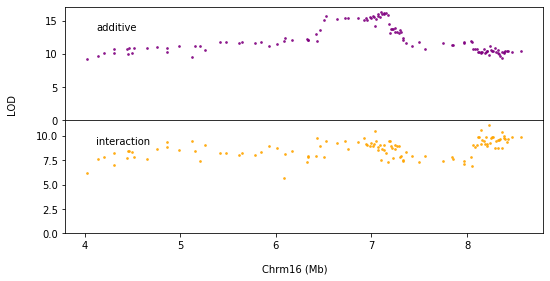

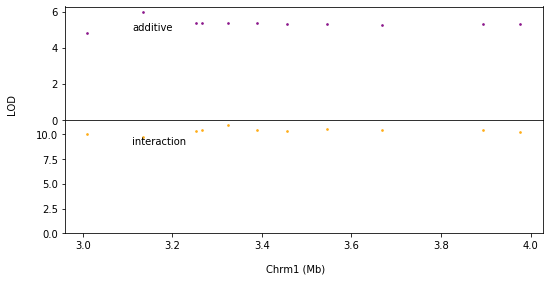

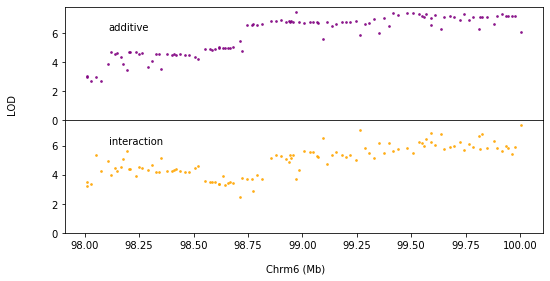

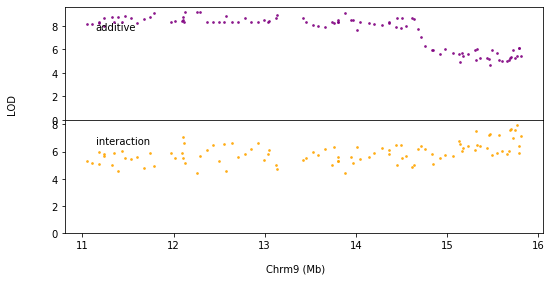

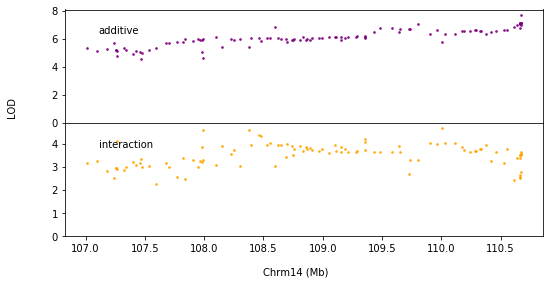

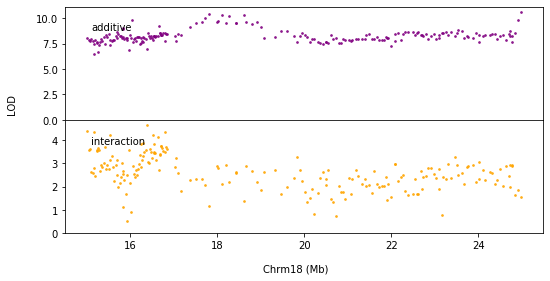

In [40]:

df_all = pd.DataFrame()
working_dir = "/home/wright/jax_cr_190429/simulation_GxEMM_200507/"

for chrm in sigloci_dict:
    locus_st = sigloci_dict[chrm][0]
    locus_end = sigloci_dict[chrm][1]
        
    output_file = output_dir+"fine_"+focal_pop+"_add.cov"+covar_add+"_int.cov"+covar_inter+"_chrm"+chrm+"."+locus_st+".csv"
    
    if os.path.isfile(output_file) is True:
        if os.stat(output_file).st_size != 0:

            df = pd.read_csv(output_file, index_col=False)
            
            figure = plot.figure(figsize=(8,4.5))
            subplots = [figure.add_axes([0.10, 0.45, 0.83, 0.35]), #xmin, ymin, dx, and dy
                        figure.add_axes([0.10, 0.10, 0.83, 0.35])]
                       
            titles = ['additive', 'interaction']
            
            subplots[0].scatter(df['location']/1e6,df['additive.LOD'],s=3, color='purple', alpha=0.8)
            subplots[1].scatter(df['location']/1e6,df['interaction.LOD'],s=3, color='orange', alpha=0.8)
            subplots[0].text(min(df['location']/1e6)+0.1, max(df['additive.LOD'])-0.1*max(df['additive.LOD']), titles[0], fontsize=10, horizontalalignment='left', verticalalignment='top')
            subplots[1].text(min(df['location']/1e6)+0.1, max(df['interaction.LOD'])-0.1*max(df['interaction.LOD']), titles[1], fontsize=10, horizontalalignment='left', verticalalignment='top')
            subplots[0].set_ylim(0,max(df['additive.LOD'])+0.05*max(df['additive.LOD']))
            subplots[1].set_ylim(0,max(df['interaction.LOD'])+0.05*max(df['interaction.LOD']))
            
            figure.text(0.5, -0.025, 'Chrm'+str(chrm)+" (Mb)", fontsize=10, horizontalalignment='center', verticalalignment='bottom')
            _ = figure.text(0., 0.5, 'LOD', fontsize=10, horizontalalignment='left', verticalalignment='center', rotation=90)
            plot.show()
            figure.savefig(plot_dir+'finemap_lod_chrm'+chrm+'.'+locus_st+'.png', dpi=400)


In [16]:
output_file

'/home/wright/do_mice/qtl_lifespan_gxemm/fine_all_add.covgen.sty.sex_int.covdiet_chrm16.4000000.csv'

In [ ]:
import matplotlib.pyplot as plot
import numpy as np
import scipy.stats

list_res_var2 = [1.0,2.0,5.0]

for res_var2_tmp in list_res_var2:

    #figure = plot.figure(figsize=(6,5))
    figure = plot.figure(figsize=(8,2.5))

    subplots = [figure.add_axes([0.10, 0.10, 0.83, 0.83])]

    titles = ['fine map']

    #for this plot - focus exclusively on simulations with 1:1 ratio in envA:envB
    df_plot = df_all[df_all['res_var2'] == res_var2_tmp] #filter to only include env_thres = 0.5
    df_plot = df_plot[df_plot['env_thres'] == 0.5]
    df1 = df_plot.groupby(['h2_true'])
    ct=0
    for idx1, grp1 in df1:
        if idx1 == 0.2 or idx1 == 0.5 or idx1 == 0.8: ##filter h2_true values to be only 0.2, 0.5, 0.8. 3 panels in plot 2B.
            df2 = grp1.groupby(['h1_true'])
            #plot
            subplots[ct].plot([0,1], [0,1], linestyle='--', linewidth=1, color='grey')
            subplots[ct].text(0.05, 0.975, titles[ct], fontsize=10, horizontalalignment='left', verticalalignment='top')

            for idx2, grp2 in df2:
                #print (ct, idx1, idx2)
                x = grp2['h1_true'].unique()
                median,lower,upper = mean_ci(grp2['gxe_h1'])
                err_diff = upper-lower
                err_center = lower+((upper-lower)/2.0)

                #plot
                #nudge=0.015
                #subplots[ct].scatter(grp2['h1_true']+nudge+0.01,grp2['gxe_h1'],s=5, edgecolor='orange', facecolor='white', alpha=0.5)
                subplots[ct].scatter(grp2['h1_true'],grp2['gxe_h1'],s=20, color='#AAAAAA', alpha=0.2)
                subplots[ct].scatter(x,median,s=100, marker='_', color='orange')
                subplots[ct].vlines(x,lower,upper, lw=1.5, color='orange')        

            ct += 1

    figure.text(0.5, -0.1, 'true h2_env1. res_var2'+str(res_var2_tmp), fontsize=10, horizontalalignment='center', verticalalignment='bottom')
    _ = figure.text(0., 0.5, 'estimated h2_env1', fontsize=10, horizontalalignment='left', verticalalignment='center', rotation=90)
    plot.show()
    figure.savefig(working_dir+'sim_gxe_3panel_res_var2'+str(res_var2_tmp)+'.png', dpi=400)
    figure.savefig(working_dir+'sim_gxe_3panel_res_var2'+str(res_var2_tmp)+'.pdf', dpi=400)

## Appendix - 1 Merge Genoprob Files from Three Studies. Create Kinship matrix in rQTL2

In [9]:
working_dir = "/home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/"

data_dir = working_dir+"source_data_dir/"
script_dir = working_dir+"scripts/"
log_dir = working_dir+"logs/"

r_script = script_dir+"merge_apr_JAC_ELL_HAR_191023.r" 
sbatch_script = r_script+".sh"
#log_file = log_dir+"merge_apr_JAC_ELL_HAR_191023.log"
log_file = log_dir+"merge_apr_JAC_ELL_HAR_200514.log"

apr_jac_file = data_dir+"prob.8state_jax_shock_191218.Rdata"
apr_ell_file = data_dir+"prob.8state_ellison_191218.Rdata"
apr_har_file = data_dir+"prob.8state_harris_191218.Rdata"

pheno_file = data_dir+"combined_lifespan_hazard_191218.csv"
merge_apr = data_dir+"prob.8state_all_191218.Rdata"

#if os.path.exists(merge_apr) is False:
fOUT = open(sbatch_script, 'w')
print ("#!/bin/bash", file=fOUT)
print ("#SBATCH --cpus-per-task=4", file=fOUT)
print ("#SBATCH --ntasks-per-node=1", file=fOUT) 
print ("#SBATCH --mem-per-cpu=15400", file=fOUT)
print ( "#SBATCH --job-name=merge", file=fOUT)
print ( "#SBATCH --partition=gpu", file=fOUT)
print ( "#SBATCH --output="+log_file, file=fOUT)
print ( "#SBATCH --error="+log_file+".err", file=fOUT)

print ( "Rscript "+r_script+" "+data_dir+" "+apr_jac_file+" "+apr_ell_file+" "+apr_har_file+" "+merge_apr+" "+pheno_file, file=fOUT)
fOUT.close()

#!ssh wright@cb "cd {working_dir}; sbatch {sbatch_script} "
print (log_file)

/home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/logs/merge_apr_JAC_ELL_HAR_200514.log


In [10]:
#log_file = '/home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/logs/merge_apr_JAC_ELL_HAR_191023.log'
log_file = '/home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/logs/merge_apr_JAC_ELL_HAR_200514.log'
#!ssh cb "squeue -u wright"
!ssh cb "head -n 4000 {log_file}"
!ssh cb "head -n 40 {log_file}.err"

[1] "input files: /home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/source_data_dir/prob.8state_jax_shock_191218.Rdata /home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/source_data_dir/prob.8state_ellison_191218.Rdata /home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/source_data_dir/prob.8state_harris_191218.Rdata"
[1] "output_base: /home/wright/do_mice/qtl_lifespan_191022_deh_ell_jac/source_data_dir/prob.8state_all_191218.Rdata"

[1] "num samples apr_jac 460"
[1] "apr_jac id post edit"
[1] "JAC_DO.0001" "JAC_DO.0002" "JAC_DO.0003" "JAC_DO.0004" "JAC_DO.0005"
[6] "JAC_DO.0006"
[1] "apr_markers"
  dimnames(apr_jac$`1`)[[3]]
1                       UNC6
2                JAX00000010
3                JAX00240603
4                JAX00240610
5                JAX00240613
6                JAX00240636

[1] "num samples apr_ell 623"
[1] "apr_ell id post edit"
[1] "ELL_9376F10.01" "ELL_9376F10.02" "ELL_9376F10.03" "ELL_9376F10.04"
[5] "ELL_9376F10.05" "ELL_9376F10.06"
[1] "apr_markers"
